In [1]:
%matplotlib inline

In [2]:
from boilerplate import *
from __future__ import print_function, division
import os, sys
import functional_vectorizer
from dio import dataio as dataio
from scipy import fftpack, signal, special
from imp import reload
style.use('dark_background')

In [3]:
# LSTM and CNN for sequence classification in the IMDB dataset
import numpy
numpy.random.seed(7)
from keras.models import Model, Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, GaussianDropout, GaussianNoise
from keras.layers import LSTM
from keras.layers.convolutional import Convolution1D, Convolution2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D, UpSampling2D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import regularizers
from keras.utils import np_utils
from sklearn import manifold
# fix random seed for reproducibility
import numpy as np, pandas as pd

Using TensorFlow backend.


In [4]:
os.chdir('/home/mike/ve/ml/')
from eegkaggle.models import crossfire, neural

In [5]:
matplotlib.rcParams['figure.figsize'] = (12,6)

In [6]:
import eegkaggle.dio.dataio as dataio
reload(dataio)

<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.pyc'>

In [7]:
# data = np.load('/run/media/mike/Elements/data/kaggle/melbourne/vectors/simple_fft_vectorizedata_train_1_X.npy')
# data = np.load('/home/mike/ve/ml/vec_sampen_9598_376.npy')
# Y = np.load('/run/media/mike/Elements/data/kaggle/melbourne/vectors/simple_fft_vectorizedata_train_1_Y.npy')
data, Y = dataio.reload_with_labels('/home/mike/ve/ml/vec_sampen_9598_376')
data_g, Y_g = dataio.reload_with_labels('/home/mike/ve/ml/vec_sampen_9607_384')
files1 = pd.read_csv('/home/mike/ve/ml/vec_sampen_9598_376_name.csv')
files2 = pd.read_csv('/home/mike/ve/ml/vec_sampen_9607_384_name.csv')

In [51]:
(x_train, y_train), (x_test, y_test) = dataio.subdiv_split_shuffle(data, Y, validation_split=.49, )
x_guess = data_g
x_train = x_train[:5600] # trimming for batch processing later
y_train = y_train[:5600]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

val_cut:  220
(5600, 16384) (5600, 1) (440, 16384) (440, 1)


In [52]:
# pd.DataFrame(y_train).to_csv('y_train.csv')
# pd.DataFrame(y_test).to_csv('y_test.csv')

In [53]:
# need to do this later
# d = dataio.subdiv_and_shuffle(x_train, y_train, resample='down')
# print(d[0].shape, d[1].shape)

In [54]:
data_a = np.concatenate([data, data_g], axis=0)
Y_a = np.concatenate([Y, Y_g ], axis=0)
files_a = pd.concat([files1, files2], axis=0)

ValueError: all the input arrays must have same number of dimensions

In [55]:
print(data_a.shape, Y_a.shape, files_a.shape, np.mean(Y_a, axis=0))

(7949, 16384) (7949, 1) (7949, 2) [-0.1835451]


In [56]:
# files.to_csv('vec_enc_lf256_16_each_label_names.csv')
# np.save('vec_enc_lf256_16_each_label', Y)


In [57]:
print(x_train.shape, x_test.shape, data_g.shape)
data_r = x_train.reshape(x_train.shape[0], -1, 16)
data_t = x_test.reshape(x_test.shape[0], -1, 16)
data_g = x_guess.reshape(data_g.shape[0], -1, 16)

# d0 = d0.reshape(d0.shape[0, -1, 16])
# d1 = d1.reshape(d1.shape[0, -1, 16])
# data_a = data_a.reshape(data_a.shape[0], -1, 16)

print(data_r.shape, data_t.shape, data_g.shape)

(5600, 16384) (440, 16384) (1908, 1024, 16)
(5600, 1024, 16) (440, 1024, 16) (1908, 1024, 16)


In [58]:
# plot(data[0])
print(data[0].shape)

(16384,)


In [59]:
std = np.std(data, axis=0)
# plt.plot(data[100]/std)
''

''

In [60]:
# Smooth the std?
# data_rs = signal.resample(data, 256, axis=1)
print(data_r.shape, data_t.shape, data_g.shape)
up, down = 4, 64
data_r_rs = signal.resample_poly(data_r, up, down, axis=1)
# data_rs = data_rs.reshape(data_rs.shape[0], 32, 32) # this is actually wrong
data_t_rs = signal.resample_poly(data_t, up, down, axis=1)
data_g_rs = signal.resample_poly(data_g, up, down, axis=1)

# data_t_rs = data_t_rs.reshape(data_t_rs.shape[0], 32, 32)
print(data_r_rs.shape, data_t_rs.shape, data_g_rs.shape)

(5600, 1024, 16) (440, 1024, 16) (1908, 1024, 16)
(5600, 64, 16) (440, 64, 16) (1908, 64, 16)


In [61]:
std = np.std(data_r_rs,axis=0)
# plt.plot(data_rs[100]/std)
# plt.imshow(data_r_rs[100]/std)
print(data_r_rs[100].shape)

(64, 16)


In [62]:
# plt.imshow(np.concatenate([data_rs[100,:32], data_rs[100,32:]], axis=1))

In [63]:
new_data = np.zeros((data_r_rs.shape[0], 32, 32))
new_test = np.zeros((data_t_rs.shape[0], 32, 32))
new_guess = np.zeros((data_g_rs.shape[0], 32, 32))

for i in range(data_r_rs.shape[0]):
    new_data[i] = np.concatenate([data_r_rs[i,:32], data_r_rs[i,32:]], axis=1)
for i in range(data_t_rs.shape[0]):
    new_test[i] = np.concatenate([data_t_rs[i,:32], data_t_rs[i,32:]], axis=1)
for i in range(data_g_rs.shape[0]):
    new_guess[i] = np.concatenate([data_g_rs[i,:32], data_g_rs[i,32:]], axis=1)
data_r_rs = new_data
data_t_rs = new_test
data_g_rs = new_guess
print(data_r_rs.shape, data_t_rs.shape, data_g_rs.shape)

(5600, 32, 32) (440, 32, 32) (1908, 32, 32)


In [64]:
# plt.imshow(data_r_rs[105])

In [65]:
y_train_cls = np_utils.to_categorical(np.asarray(y_train, dtype=int), 2)
y_test_cls = np_utils.to_categorical(np.asarray(y_test, dtype=int), 2)

# print(y_cls)

In [66]:
mean = np.mean(data_r_rs, axis=0)
std = np.std(data_r_rs, axis=0)
# gmean = np.mean(data)
# gstd = np.std(data)
# mean.shape, gstd.shape

In [67]:
# zdata = (data_rs - mean) / (std*4)
zdata = (data_r_rs) / (std*4)
zdata_t = (data_t_rs) / (std*4)
zdata_g = (data_g_rs) / (std*4)

print('min {} max: {}'.format(np.amin(zdata), np.amax(zdata)))
zdata = np.nan_to_num(zdata)
zdata_t = np.nan_to_num(zdata_t)
zdata_g = np.nan_to_num(zdata_g)

print(zdata.shape, zdata_t.shape, y_train.shape, y_test.shape)

min -2.10708184604 max: 5.27072193084
(5600, 32, 32) (440, 32, 32) (5600, 1) (440, 1)


In [68]:
# plt.plot(zdata[100,:])
print(zdata[100].shape)

(32, 32)


In [69]:
# plt.plot(zdata_t[1900])
''

''

In [70]:
# plt.imshow(zdata[101])

In [71]:
# data = dataio.get_matlab_eeg_data_ary('/home/mike/data/train/1_1001_0.mat')

In [72]:
# ds = signal.resample(zdata[0:], 256, axis=1)
ds = zdata
ds = np.tanh(ds)
x_test = np.tanh(zdata_t)
x_guess = np.tanh(zdata_g)

# ds = np.log(ds)
# ds = special.erf(ds)
print(ds.shape,  x_test.shape, Y.shape,)
# plt.plot(ds[4000])
''

(5600, 32, 32) (440, 32, 32) (6041, 1)


''

In [73]:
print(np.mean(ds), np.mean(x_test))
print(np.std(ds), np.std(x_test))

0.43299654551 0.421841146506
0.206965885473 0.206536117584


In [74]:
# ds2 = ds.reshape(ds.shape[0], -1)
# ds2 = ds.reshape(ds.shape[0]*16, -1)
# Serialize the electrodes so that there is 1 electrode per sample
# ds2 = []
# for i in range(16):
#     ds2.append( ds[:,:,i])
# ds2 = np.concatenate(ds2, axis=0)
# ds2.shape

Building Autoencoder

In [75]:
x_train = ds.reshape((ds.shape[0], ds.shape[1], ds.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_guess = x_guess.reshape((x_guess.shape[0], x_guess.shape[1], x_guess.shape[2], 1))

input_shape = (ds.shape[1], ds.shape[2], 1)

batch_size=100
print(input_shape, x_train.shape, x_test.shape, x_guess.shape, y_train_cls.shape)
# vaeclass = crossfire.CrossfireEEG(input_shape=input_shape, latent_dim=16, batch_size=batch_size, n_classes=2)

(32, 32, 1) (5600, 32, 32, 1) (440, 32, 32, 1) (1908, 32, 32, 1) (5600, 2)


# Inline building of ConvAE

In [76]:
class SimpleCrossfire(object):
    """
    Covolutional VAE with a "crossfire" component - a classifier is bolted onto the end of the encoder and loss function
    can be parameterized to function from classifier loss instead of autoencoder loss. Ideally, the model starts in
    pure autoencoder mode to learn features, then as loss flattens out the network starts weighing classifier loss
    more heavily.
    Refs: 
    https://stackoverflow.com/questions/39181976/keras-convolutional-autoencoder-layer-shapes
    Note to self: things to try:
    * Add burst /batch / epoch noise to input
    * Modularize out the activation from dropout ordering"""

    def __init__(self, input_shape=(28, 28, 1), latent_dim=2, intermediate_dim=256, batch_size=100, epsilon_std=1.0,
                 dropout_p=0.1, n_stax=0, n_classes=10):
        # input image dimensions
        self.input_shape = input_shape
        
        self.batch_size = batch_size
        self.original_dim = np.prod(input_shape)
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.epsilon_std = epsilon_std
        self.epsilon_ce = 1.0e-9

        # number of convolutional filters to use
        nb_filters = 64
        # convolution kernel size
        nb_conv = 3

        input_img = Input(shape=(1, input_shape[0], input_shape[1]))

        # Same as the code above, but with some params changed
        # Now let's define the model.

        # (no.of, colour, channels, height, width) = (3, 30, 30)
        # Set input dimensions:
        imchn = 3  # channels
        imwid = 30 # width
        imhei = 30 # height
        input_img = Input(shape=(imchn, imhei, imwid))
        nb_filters1 = 128
        nb_filters2 = 64
        nb_filters3 = 64

        # Encoder: define a chain of Conv2D and MaxPooling2D layers
        x = Convolution2D(128, nb_conv, nb_conv, activation='relu', border_mode='same')(input_img)
        x = MaxPooling2D((2, 2), border_mode='same')(x)
        x = Convolution2D(64, nb_conv, nb_conv, activation='relu', border_mode='same')(x)
        x = MaxPooling2D((2, 2), border_mode='same')(x)
        x = Convolution2D(64, nb_conv, nb_conv, activation='relu', border_mode='same')(x)
        encoded = MaxPooling2D((2, 2), border_mode='same')(x)

        # at this point, the representation is (8, 4, 4) i.e. 128-dimensional

        # Decoder: a stack of Conv2D and UpSampling2D layers
        x = Convolution2D(64, nb_conv, nb_conv, activation='relu', border_mode='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Convolution2D(64, nb_conv, nb_conv, activation='relu', border_mode='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Convolution2D(128, nb_conv, nb_conv, activation='relu', border_mode='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)
        # Generate models
        # Primary model - VAE
        ## ==== Crossfire classifier =========
        #         c = Lambda(self.crosser, output_shape=(latent_dim,))(self.z_mean, self.z_log_var)
#         classer = Dense(n_classes, init='normal', activation='softmax', name='classer')(encoded)
#         self.ae = Model(input_img, decoded)
#         self.ae.compile(optimizer='rmsprop', loss='binary_crossentropy')
        self.ae = Model(input_img, decoded)
        self.ae.compile(optimizer='adadelta', loss='mse')
        # Crossfilre network
        if False:
            self.classifier = Model(x, classer)
            # Ok, now comes the tricky part. See these references:
            # https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
            self.crossmodel = Model(input=x, output=[decoded, classer])
            self.crossmodel.compile(optimizer='rmsprop',
                                    loss={'main_output': self.vae_loss,
                                          'classer': 'categorical_crossentropy'},
                                    loss_weights={'main_output': 1.0,
                                                  'classer': 1.0})
            self.classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            # self.classifier.compile(loss=self.custom_crossent, optimizer='adam', metrics=['accuracy'])


        # build a model to project inputs on the latent space
#         self.encoder = Model(x, encoded)
        # reconstruct digits from latent space
        # self.generator = Model(decoder_input, _x_decoded_mean_squash)

    

In [77]:
# not in use at the moment
#vaeclass = SimpleCrossfire(input_shape=input_shape, latent_dim=16, batch_size=batch_size, n_classes=2)
# vaeclass.ae.summary()

In [78]:
# cnnclass = neural.Simple_Convo_Classer(input_shape[0:2], nb_classes=2)

# Fitting the autoencoder

In [79]:
# assert 0
from keras import objectives
from keras.datasets import mnist
from keras.utils import np_utils
from keras import models
import keras.layers.core as core
import keras.layers.convolutional as conv


In [80]:
batch_size = 128
img_rows, img_cols = 32, 32
nb_classes = 2

nb_filters_1 = 32  # 32 # 64
nb_filters_2 = 64  # 64 # 128
nb_filters_3 = 128  # 128 # 256
nb_conv = 3

trainX = ds
print(trainX.shape)
sigma= 0.1
drop_p=0.2

cnn = models.Sequential()
cnn.add(GaussianNoise(sigma, input_shape=(img_rows, img_cols, 1)))
cnn.add(Dropout(drop_p))
cnn.add(conv.Convolution2D(nb_filters_1, nb_conv, nb_conv, activation="relu",border_mode='same'))
cnn.add(BatchNormalization())
cnn.add(Dropout(drop_p))
cnn.add(conv.Convolution2D(nb_filters_1, nb_conv, nb_conv, activation="relu", border_mode='same'))
cnn.add(conv.MaxPooling2D(strides=(2, 2)))

cnn.add(conv.Convolution2D(nb_filters_2, nb_conv, nb_conv, activation="relu", border_mode='same'))
cnn.add(conv.Convolution2D(nb_filters_2, nb_conv, nb_conv, activation="relu", border_mode='same'))
cnn.add(conv.MaxPooling2D(strides=(2, 2)))

# cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu", border_mode='same'))
# cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu", border_mode='same'))
# cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu", border_mode='same'))
# cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu", border_mode='same'))
# cnn.add(conv.MaxPooling2D(strides=(2,2)))

cnn.add(core.Flatten())
cnn.add(core.Dropout(0.2))
cnn.add(core.Dense(128, activation="relu"))  # 4096
cnn.add(core.Dense(nb_classes, activation="softmax"))

cnn.summary()

(5600, 32, 32)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
gaussiannoise_2 (GaussianNoise)  (None, 32, 32, 1)     0           gaussiannoise_input_2[0][0]      
____________________________________________________________________________________________________
dropout_4 (Dropout)              (None, 32, 32, 1)     0           gaussiannoise_2[0][0]            
____________________________________________________________________________________________________
convolution2d_21 (Convolution2D) (None, 32, 32, 32)    320         dropout_4[0][0]                  
____________________________________________________________________________________________________
batchnormalization_6 (BatchNormal(None, 32, 32, 32)    64          convolution2d_21[0][0]           
____________________________________________________________________________

In [37]:
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [35]:
print(x_train.shape, y_train_cls.shape, x_test.shape, y_test_cls.shape)

(5593, 32, 32, 1) (5593, 2) (448, 32, 32, 1) (448, 2)


In [39]:
np.sum(y_train_cls, axis=0)

array([ 5368.,   225.])

In [36]:
reload(dataio)
x_sub, y_sub = dataio.shuffle_split_with_label(x_train, y_train, seed=i)
y_sub_cls = np_utils.to_categorical(np.asarray(y_sub, dtype=int), 2)


In [81]:
assert 0
nb_mega = 10
for i in range(nb_mega):
    print('Mega-epoch {} of {}', i, nb_mega)
    seed = i
#     np.random.seed(seed)
#     np.random.shuffle(ds)
#     np.random.seed(seed)
#     np.random.shuffle(Y_cls)
    x_sub, y_sub = dataio.shuffle_split_with_label(x_train, y_train, seed=i)
    y_sub_cls = np_utils.to_categorical(np.asarray(y_sub, dtype=int), 2)
    cnn.fit(x_sub, y_sub_cls, batch_size=batch_size, nb_epoch=3, validation_data=(x_test, y_test_cls), shuffle=True) #, class_weight={0:y_wts[0], 1:y_wts[1]})

AssertionError: 

In [82]:
x_train.shape, x_test.shape, y_train.shape

((5600, 32, 32, 1), (440, 32, 32, 1), (5600, 1))

In [83]:
x_train2 = x_train[:,:28, :28]
x_test2 = x_test[:,:28, :28]
x_train2.shape, x_test2.shape

((5600, 28, 28, 1), (440, 28, 28, 1))

In [91]:
y_train.shape, y_test.shape

((5600, 1), (440, 1))

In [84]:
reload(crossfire)
batch_size=100
cf = crossfire.Crossfire2((28,28,1), latent_dim=16, batch_size=batch_size, n_classes=2)

In [85]:
cf.fit_ae(x_train2, batch_size=batch_size, nb_epoch=1)

Epoch 1/1
5600/5600 [==============================] - 9s - loss: 1080.2588     


Train on 5600 samples, validate on 400 samples
Epoch 1/1
5600/5600 [==============================] - 3s - loss: 0.1645 - acc: 0.9593 - val_loss: 0.6854 - val_acc: 0.5500


In [93]:

nb_mega = 10
for i in range(nb_mega):
    print('Mega-epoch {} of {}', i, nb_mega)
    seed = i
    x_sub, y_sub = dataio.shuffle_split_with_label(x_train2, y_train, seed=i)
    y_sub_cls = np_utils.to_categorical(np.asarray(y_sub, dtype=int), 2)
    cf.classifier.fit(x_train2, y_train_cls, batch_size=batch_size, nb_epoch=1, validation_data=(x_test2[:400], y_test_cls[:400]))

Mega-epoch {} of {} 0 10
Train on 5600 samples, validate on 400 samples
Epoch 1/1
5600/5600 [==============================] - 3s - loss: 0.1620 - acc: 0.9593 - val_loss: 0.6826 - val_acc: 0.5500
Mega-epoch {} of {} 1 10
Train on 5600 samples, validate on 400 samples
Epoch 1/1
5600/5600 [==============================] - 3s - loss: 0.1591 - acc: 0.9593 - val_loss: 0.6816 - val_acc: 0.5500
Mega-epoch {} of {} 2 10
Train on 5600 samples, validate on 400 samples
Epoch 1/1
5600/5600 [==============================] - 3s - loss: 0.1571 - acc: 0.9593 - val_loss: 0.6798 - val_acc: 0.5500
Mega-epoch {} of {} 3 10
Train on 5600 samples, validate on 400 samples
Epoch 1/1
5600/5600 [==============================] - 3s - loss: 0.1539 - acc: 0.9593 - val_loss: 0.6712 - val_acc: 0.5500
Mega-epoch {} of {} 4 10
Train on 5600 samples, validate on 400 samples
Epoch 1/1
5600/5600 [==============================] - 3s - loss: 0.1493 - acc: 0.9593 - val_loss: 0.6646 - val_acc: 0.5500
Mega-epoch {} of {} 

In [42]:
pred = cnn.predict(x_train, batch_size=batch_size)
print(pred.shape)

(5593, 2)


In [43]:
pred_c = pred > 0.5
print('Prediction distribution: ', np.mean(pred_c, axis=0))

Prediction distribution:  [ 0.50044699  0.49955301]


In [44]:
print('Training Set Accuracy: ', np.mean(pred_c == y_train_cls, axis=0))

Training Set Accuracy:  [ 0.53423923  0.53423923]


In [45]:
pred_test = cnn.predict(x_test, batch_size=batch_size)
print(pred_test.shape)
pred_c = pred_test > 0.5
print(pred_c.shape, y_test_cls.shape)
print('Prediction distribution: ', np.mean(pred_c, axis=0))
print('Test Set Accuracy: ', np.mean(pred_c == y_test_cls, axis=0))

(448, 2)
(448, 2) (448, 2)
Prediction distribution:  [ 0.37053571  0.62946429]
Test Set Accuracy:  [ 0.69642857  0.69642857]


In [46]:
guess = cnn.predict(x_guess, batch_size=batch_size)

In [47]:
guess_c = guess > 0.5
np.mean(guess_c, axis=0)

array([ 0.48689727,  0.51310273])

In [48]:
np.mean(guess, axis=0)

array([ 0.51380837,  0.48619169], dtype=float32)

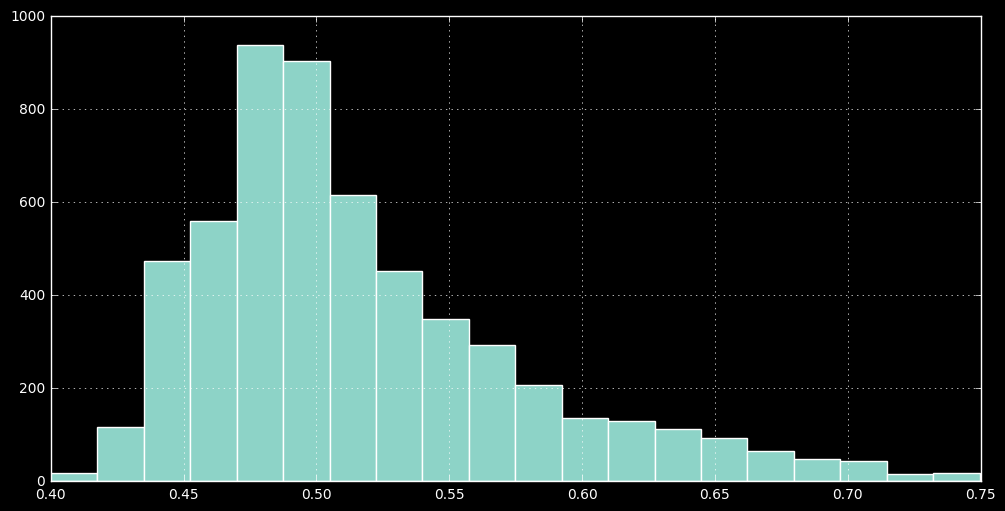

In [49]:
pd.Series(pred[:,0]).hist(bins=20)

In [ ]:
pd.Series(guess[:,0]).hist(bins=20)

In [ ]:
import os,time

In [ ]:
files2['Class'] = pd.Series(guess_c[:,0], dtype=int)
files2['File'] = pd.Series([os.path.basename(nm) for nm in files2['path']])

In [ ]:
files2.to_csv('./eegkaggle/guesses/new_cnn_11_26_{}.csv'.format('a')) # fix this 

In [ ]:
assert 0

In [ ]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder2.predict(x_train[:3000])
decoded_imgs = decoder2.predict(encoded_imgs)

In [ ]:
for i in range(20):
    plot(decoded_imgs[np.random.randint(0, decoded_imgs.shape[0])])
    
plot(np.mean(decoded_imgs, axis=0), 'w--', lw=2)
plot(np.mean(decoded_imgs, axis=0), 'r', lw=.5)

In [ ]:
for i in range(1,20*17,17): 
    plt.plot(decoded_imgs[i])

In [ ]:
st = 2001
n = 10
nx = range(st,st+n*17,17)
print(nx)
c = ['r', 'g', 'b', 'm', 'c', 'y']
for i in range(3):
    j = nx[i]
    plt.plot(decoded_imgs[j], c[i])
    plt.plot(ds2[j], c[i]+'--')

In [ ]:
tsne1 = manifold.TSNE(2, 30, n_iter=5000)

In [ ]:
txdata1 = tsne1.fit_transform(ds2[::15])

In [ ]:
tsne3 = manifold.TSNE(2, 30, n_iter=5000)

In [ ]:
txdata3 = tsne3.fit_transform(ds2[::11])

In [ ]:
txdata1.shape

In [ ]:
6041. / ( ds2.shape[0] / 16) * (ds2.shape[0] / 15)

In [ ]:
nZeros

In [ ]:
txdata2 = np.array(txdata1)

In [ ]:
# plt.scatter(txdata1[:,0], txdata1[:,1])
nTrain = 6443
nZeros = 5964
cut = nZeros
nOnes = nTrain-nZeros

plt.scatter(txdata2[:cut,0], txdata2[:cut,1], c='w', s=5, marker='.',   edgecolors='none')
plt.scatter(txdata2[cut:nTrain,0], txdata2[cut:nTrain,1], c='orange', s=500, marker='.', edgecolors='none', alpha=0.05)
plt.scatter(txdata2[cut:nTrain,0], txdata2[cut:nTrain,1], c='r', s=10, marker='.', edgecolors='none')
plt.scatter(txdata2[nTrain:,0], txdata2[nTrain:,1], c='b', s=10, marker='.', edgecolors='none')

In [ ]:
6041. / ( ds2.shape[0] / 16) * (ds2.shape[0] / 11)

In [ ]:
nTrain = int(6041 * txdata3.shape[0] / (ds2.shape[0] / 16) )
nZeros = int( nTrain * (5592/6041))
cut = nZeros
plt.scatter(txdata3[:cut,0], txdata3[:cut,1], c='w', s=5, marker='.',   edgecolors='none')
plt.scatter(txdata3[cut:nTrain,0], txdata3[cut:nTrain,1], c='orange', s=500, marker='.', edgecolors='none', alpha=0.05)
plt.scatter(txdata3[cut:nTrain,0], txdata3[cut:nTrain,1], c='r', s=10, marker='.', edgecolors='none')
plt.scatter(txdata3[nTrain:,0], txdata3[nTrain:,1], c='b', s=10, marker='.', edgecolors='none')

In [ ]:
# ae2.save('ae_lf256_16.h5')

In [ ]:
# encoder2.save('enc_lf256_16.h5')

In [ ]:
encoded_imgs.shape
np.save('vec_enc_lf256_16_each', encoded_imgs)

In [ ]:
os.chdir('/home/mike/ve/ml/')
from eegkaggle.dio import dataio
reload(dataio)

In [ ]:
reload(dataio)
print(zdata.shape, Y.shape)
d0, d1, dt = dataio.separate_sets(zdata, Y)
print(d0.shape, d1.shape)
x,y = dataio.subdiv_and_shuffle(zdata, Y, resample='up', merge=False, shuffle=False) # let keras shuffle
# x = zdata
# y = Y

In [ ]:
print(x.shape, y.shape)

In [ ]:
np.mean(y, axis=0)

In [ ]:
y

In [ ]:
Yv = np.asarray(y == 1).ravel()
print(Yv)
Yv = np.stack([Yv, ~Yv], axis=1)
print(Yv.shape)
Yv = np.array(Yv, dtype=int)
print(Yv.shape)
np.mean(Yv[:,0])

In [ ]:
print(x.shape, Yv.shape)

In [ ]:
X_train = x
# X_train = x.reshape(-1, 256,1)
# X_train /= np.amax(X_train)
y_train = Yv # .reshape(-1, 2)
print(X_train.shape, y_train.shape)
ones_rate = np.mean(Yv[:,0])
class_weight= {0:1./(1-ones_rate), 1:1./ones_rate}
print(class_weight)
model.fit(X_train, y_train, nb_epoch=3, batch_size=64, shuffle=True, class_weight=class_weight, validation_split=0.2 )

In [ ]:
pr = model.predict_classes(X_train)

In [ ]:
np.sum(pr)

In [ ]:
pr.shape

In [ ]:
np.mean(pr == y_train[:,1]) # MOMENT OF TRUUUUUTH!!!!!!